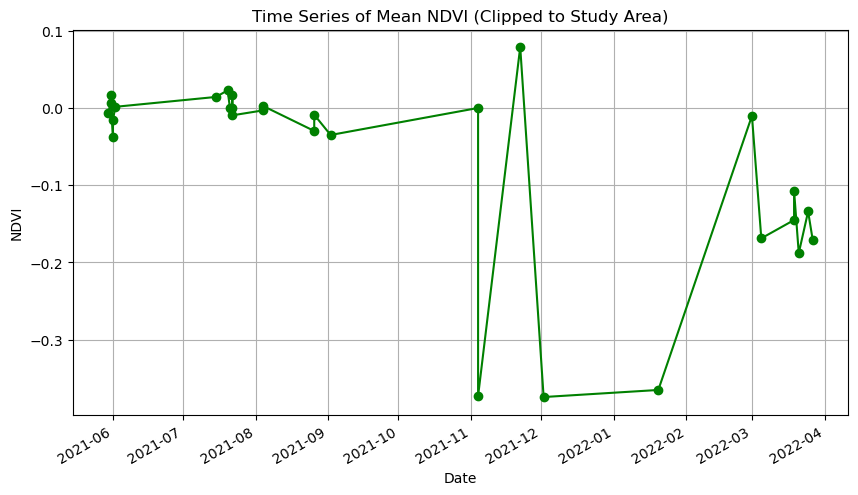

In [8]:
# Import libraries
import os                      
from pathlib import Path
import geopandas as gpd        
import pandas as pd  
import rioxarray as rxr         
import xarray as xr             
import numpy as np              
import matplotlib.pyplot as plt 
from dask.distributed import Client


# Initialize Dask client for parallel computing 
client = Client()
client.close()

# 1. Load vector boundary (study area polygon) and convert to desired crs
boundary = gpd.read_file("/Data/Shp_files/Esthwait.shp") 
boundary = boundary.to_crs(epsg=32630)

# 2. List all TIFF files in directory
planet_scenes =Path("/Data/Scenes")
tif_files = sorted([f for f in os.listdir(planet_scenes) if f.endswith(".tif")], key=lambda x: x.split("_")[0])

# 3. Define function to process each scene (lazily with Dask)
def process_scene(tif_path):
    """Load, clip, and calculate NDVI for a single PlanetScope scene."""
    # Open TIFF
    ds = rxr.open_rasterio(f"{planet_scenes}/{tif_path}", chunks={'x': 1024, 'y': 1024})  # 'auto' optimizes chunk size
    
    # list of shapely geometries
    geoms = list(boundary.geometry)

    # clip raster
    ds_clipped = ds.rio.clip(geoms, boundary.crs)
    
    # Extract Red (B3) and NIR (B4) bands and scale to reflectance (0-1)
    red = ds_clipped.sel(band=3).astype("float32") / 10000  # PlanetScope scale factor
    nir = ds_clipped.sel(band=4).astype("float32") / 10000
    
    # Calculate NDVI: (NIR - Red) / (NIR + Red + epsilon to avoid division by zero)
    ndvi = (nir - red) / (nir + red + 1e-6)  
    ndvi.name = "NDVI"  # Label the DataArray
    
    # Parse date from filename (e.g., "20230101_redsea.tif" -> January 1, 2023)
    date_str = tif_path.split("_")[0]  
    ndvi["time"] = pd.to_datetime(date_str)
    return ndvi

# 4. Process all scenes lazily
ndvi_list = [process_scene(f) for f in tif_files]  # List of lazy NDVI DataArrays

# 5. Combine into a single time-series xarray Dataset
ndvi_stack = xr.concat(ndvi_list, dim="time") 

# 6. Compute mean NDVI over the study area
mean_ndvi = ndvi_stack.mean(dim=["x", "y"]).compute() 

# 7. Plot time series
plt.figure(figsize=(10, 5))
mean_ndvi.plot(marker="o", linestyle="-", color="green")
plt.title("Time Series of Mean NDVI (Clipped to Study Area)")
plt.ylabel("NDVI")
plt.xlabel("Date")  
plt.grid()           
plt.savefig("Results/ndvi_time_series.png", dpi=300) 
plt.show();           

# 8. Save NDVI stack for future use 
# ndvi_stack.to_netcdf("Results/ndvi_stack.nc")

# 9. Clean up Dask client
client.close()